In [77]:
import gensim, logging
import os
from gensim.models.word2vec import PathLineSentences, LineSentence
import pandas as pd
import imp
from tqdm import tqdm_notebook
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [2]:
import sys
sys.path.append('/Users/ak/Yandex.Disk.localized/sentiment-neural_past_from_Denis_Kirjanov/src')

In [3]:
from nltk_sent_tokenize_binding import NLTKSentenceTokenizer

Выгрузим предобученный word2vec

In [4]:
root_path = '/Users/ak/Yandex.Disk.localized/Магистратура ВШЭ/Chat_word_autofill/'
embedding = gensim.models.Word2Vec
embedding = embedding.load(root_path + 'model_normalized_with_chats_2.bin')

Загрузим обучающую выборку (сайты отзывов + самостоятельно размеченно из чатов)

In [5]:
data1 = pd.read_csv('data_sentences.csv')
data1.head()

/Users/ak/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,score,source,text
0,0,5,foursquare,"2 рабочих места, выделенное рабочее место по к..."
1,1,5,foursquare,"pos-терминал, сенсорный экран для управления ""..."
2,2,5,foursquare,очереди имеются.
3,3,5,foursquare,"free wi-fi ""tattelecom_unlim"" :) good while wa..."
4,4,5,foursquare,so pretty interior though


In [6]:
data2 = data1[['text', 'score', 'source']].copy()

In [7]:
samples = pd.read_csv('samples_from_client_mes.csv', 
                      encoding='mac_cyrillic', 
                      delimiter=';', 
                      names=['text', 'score'], 
                     skiprows=1)
samples.score.fillna(value=3, inplace=True)
samples.score.replace(to_replace={'полож':5, 'отриц':1, "п":5, "о":1}, inplace=True)
samples.text = samples.text.str.replace('& amp, quo,', '')
samples.head()

,text,score
0,Ок. .. Пошел почитаю. .. С утром вас. .. Светит,3
1,"Хорошо, вклад хочу открыть под максимальную ст...",3
2,Хочу вклад открыть под максимальную ставку,3
3,как я открыть могу открыть брокерский счет ?,3
4,как я открыть могу открыть брокерский счет ?,3


In [8]:
samples.score.value_counts()

3    14964
5      637
1       95
Name: score, dtype: int64

In [9]:
data1.score.value_counts()

1    275811
5    129077
3    106110
2     54943
4     20699
0         3
Name: score, dtype: int64

Разобъем клиентские сообщения из чатов на предложения

In [10]:
sentences = []
scores = []
sources = []
false_stoppings = ["лат", "греч", "проц", "млн", "млрд", "итал", "фр", "рус", "кв", "м", "тыс", "руб", "англ", "п",
                       "ст", "гор", "обл", "пос", "д", "дер", "др", "пр", "рег", "ул", "к", "т.е", "т.п", "юр", "физ"]
sentence_tokenizer = NLTKSentenceTokenizer(false_stoppings)
progress_bar = tqdm_notebook(total=samples.shape[0])
for text, score in zip(samples.text.values, samples.score.values):
    for sentence in text.split('\n'):
        s = sentence_tokenizer(sentence)
        sentences.extend(s)
        scores.extend([score for x in s])
        sources.extend(['chat' for x in s])
    progress_bar.update(1)
progress_bar.close()

HBox(children=(IntProgress(value=0, max=15696), HTML(value='')))

In [11]:
samples_sentences = pd.DataFrame({'text':sentences, 'score':scores, 'source':sources})

In [12]:
data = pd.concat([data2, samples])

In [13]:
data.head()

,score,source,text
0,5,foursquare,"2 рабочих места, выделенное рабочее место по к..."
1,5,foursquare,"pos-терминал, сенсорный экран для управления ""..."
2,5,foursquare,очереди имеются.
3,5,foursquare,"free wi-fi ""tattelecom_unlim"" :) good while wa..."
4,5,foursquare,so pretty interior though


Загрузка модели для нормализации текстов

In [14]:
import pickle
with open('model_tokenize.pkl', 'rb') as f:
    normalizer = pickle.load(f)

In [15]:
def norm12345(s):
    tokens = normalizer.lemmatizer.process(s)
    return ' '.join(tokens)

In [39]:
%%time
pool = multiprocessing.Pool(3)
sent_norm = pool.map(norm12345, samples_sentences.text.values)

CPU times: user 30.9 ms, sys: 37.3 ms, total: 68.1 ms
Wall time: 4.34 s


In [32]:
sentences_prev = pd.read_csv('sentences_normalized.txt', header=None)

In [33]:
len(sentences_prev)

557286

In [38]:
len(data1)

586643

In [40]:
len(sent_norm)

18164

In [41]:
len(samples_sentences)

18164

In [42]:
samples_sentences['text_normalized'] = sent_norm

In [43]:
samples_sentences.head(20)

,score,source,text,text_normalized
0,3,chat,Ок. .. Пошел почитаю.,ока пойти почитать
1,3,chat,.. С утром вас.,утро
2,3,chat,.. Светит,светить
3,3,chat,"Хорошо, вклад хочу открыть под максимальную ст...",хорошо вклад хотеть открывать максимальный ставка
4,3,chat,Хочу вклад открыть под максимальную ставку,хотеть вклад открывать максимальный ставка
5,3,chat,как я открыть могу открыть брокерский счет ?,открывать мочь открывать брокерский счет
6,3,chat,как я открыть могу открыть брокерский счет ?,открывать мочь открывать брокерский счет
7,3,chat,как я открыть могу открыть брокерский счет ?,открывать мочь открывать брокерский счет
8,3,chat,"хочу карту открыть, что можете посоветовать ?",хотеть карта открывать мочь посоветовать
9,3,chat,"хочу карту открыть, что можете посоветовать ?",хотеть карта открывать мочь посоветовать


In [47]:
samples_sentences[samples_sentences.score == 1]

,score,source,text,text_normalized
28,1,chat,Отлично.,отлично
29,1,chat,Потерял карту.,потерять карта
30,1,chat,А пин-код изменится ?,пин код изменяться
521,1,chat,"Как плохо, а они тогда как быстро сгорают ?",плохо тогда быстро сгорать
1022,1,chat,не один из предложенных вариантов не подошёл,не предлагать вариант не подходить
1036,1,chat,Не могу совершить покупки в интернете через карту,не мочь совершать покупка интернет через карта
1243,1,chat,"А потом вы берете и отказываете, где логика ?",потом берет отказывать логика
2720,1,chat,У меня банкомат карту захватил.,банкомат карта захватить
2721,1,chat,Что мне делать,делать
3026,1,chat,Жаль.,жаль


Построим распределение представлений. Это полезно проделать для понимания того, стоит ли применять линейные методы

In [16]:
vect_reshape = embedding.wv.vectors.reshape(-1, 1)

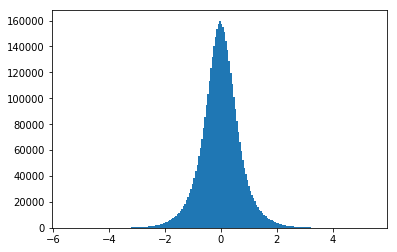

In [56]:
_ = plt.hist(vect_reshape, bins=200)

In [58]:
vect_reshape.mean(), vect_reshape.std(), vect_reshape.var()

(-0.0049994807, 0.7040981, 0.49575418)

In [66]:
%%time
pool = multiprocessing.Pool(3)
sent_norm_data1 = pool.map(norm12345, data1.text.values)

CPU times: user 1.06 s, sys: 588 ms, total: 1.65 s
Wall time: 2min 12s


In [67]:
data1['text_normalized'] = sent_norm_data1

In [68]:
data1.head(60)

,Unnamed: 0,score,source,text,text_normalized
0,0,5,foursquare,"2 рабочих места, выделенное рабочее место по к...",рабочий место выделять рабочий место кредит касса
1,1,5,foursquare,"pos-терминал, сенсорный экран для управления ""...",pos терминал сенсорный экран для управление сб...
2,2,5,foursquare,очереди имеются.,очередь иметься
3,3,5,foursquare,"free wi-fi ""tattelecom_unlim"" :) good while wa...",free wi fi tattelecom good while waiting
4,4,5,foursquare,so pretty interior though,so pretty interior though
5,5,3,foursquare,аппарат по выдачи талонов сломан!,аппарат выдача талон сломать
6,6,3,foursquare,"вспоминаем старую, ""добрую"" очередь, как в пол...",вспоминать старый добрый очередь поликлиника
7,7,2,foursquare,в сбербанке установили новую программу-теперь ...,сбербанк устанавливать новый программа теперь ...
8,8,2,foursquare,класс.,класс
9,9,2,foursquare,"в сбере, как обычно, ""приятные ноу-хау""…",сбер обычно приятный ноу хау


In [69]:
data2 = data1[['text', 'text_normalized', 'score', 'source']].copy()

In [70]:
data = pd.concat([data2, samples_sentences])

In [71]:
data.head()

,score,source,text,text_normalized
0,5,foursquare,"2 рабочих места, выделенное рабочее место по к...",рабочий место выделять рабочий место кредит касса
1,5,foursquare,"pos-терминал, сенсорный экран для управления ""...",pos терминал сенсорный экран для управление сб...
2,5,foursquare,очереди имеются.,очередь иметься
3,5,foursquare,"free wi-fi ""tattelecom_unlim"" :) good while wa...",free wi fi tattelecom good while waiting
4,5,foursquare,so pretty interior though,so pretty interior though


In [ ]:
data = 

In [78]:
data['len'] = data.text_normalized.apply(lambda x: len(str(x).split()))

In [79]:
data['len'].value_counts()

1      54450
3      52998
4      52426
2      50196
5      48027
6      44485
7      39930
8      34760
9      29654
0      29417
10     25692
11     21700
12     18588
13     15985
14     13408
15     11261
16      9882
17      7949
18      6768
19      5468
20      4861
21      3910
22      3293
23      2736
24      2289
25      1997
26      1663
27      1466
28      1206
29      1115
       ...  
132        1
176        1
136        1
141        1
159        1
142        1
150        1
591        1
115        1
112        1
571        1
574        1
568        1
575        1
563        1
576        1
599        1
319        1
601        1
582        1
583        1
608        1
97         1
610        1
100        1
588        1
615        1
107        1
619        1
330        1
Name: len, Length: 156, dtype: int64

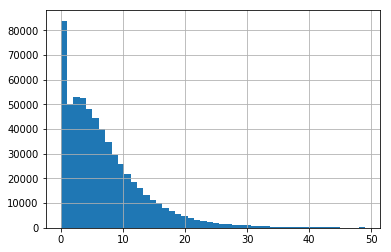

In [80]:
data[data['len'] < 50]['len'].hist(bins=48)

In [81]:
data[data['len'] == 0]

,score,source,text,text_normalized,len
10,2,foursquare,),,0
52,1,foursquare,:(.,,0
65,5,foursquare,…,,0
66,5,foursquare,… …,,0
84,5,foursquare,23.,,0
177,3,foursquare,:/,,0
198,5,foursquare,:)),,0
220,1,foursquare,!!!!!,,0
307,5,foursquare,; ),,0
317,5,foursquare,30).,,0


In [82]:
len(data)

604807

In [83]:
data.to_csv('all_data_normalized.csv')